# 적대적 생성 신경망(Generative Adversarial Networks, GAN)

- 2014년, Ian Goodfellow 소개

- VAE와는 다른 방법으로 이미지 잠재 공간을 학습

- 직관적으로 이해하는 방법

  - 가짜 피카소 그림을 그리는 위조범과 이를 판별하는 판매상의 관계

  - 위조품과 진짜 그림을 섞어서 판매상에게 보여주며  
    그림이 진짜인지 가짜인지 판매상은 판별하고 이를 위조범에게 피드백

  - 처음에는 형편없는 그림을 그리다가 점점 피카소의 스타일을 모방하게 되고  
    판매상은 위조품을 구분하는데 점점 더 전문가가 되어감

- GAN의 네트워크

  - 생성자 네트워크(generator network)

    - 랜덤 벡터(잠재 공간의 무작위한 포인트)를 입력으로 받아 이를 합성된 이미지로 디코딩

  - 판별자 네트워크(discriminator netowrk)

    - 이미지(실제 또는 가짜 이미지)를 입력으로 받아 훈련 세트에서 온 이미지인지 생성자가 만든 이미지인지 판별

- GAN은 최적화의 최솟값이 고정되어 있지 않음

  - 보통의 경사하강법은 **고정된 손실공간**에서 언덕을 내려오는 훈련 방법이지만  
    GAN은 매 단계가 조금씩 전체 공간을 바꾸기 때문에 최적화 과정이 최솟값을 찾는 것이 어려움

  - 두 힘간의 평형점을 찾는 시스템

  - 따라서, 학습과정이 매우 어려움  
    즉, 적절한 파라미터를 찾고 조정해야함
  
  <img src="https://paperswithcode.com/media/methods/gan.jpeg">

  <sub>[이미지 출처] https://paperswithcode.com/method/gan</sub>


In [ ]:
잠재변수: 숨겨진 변수로써 현재 데이터에 영향을 끼치는 변수
잠재 변수를 이용해 해당 데이터와 유사한 데이터 생성해냄
EX) 생성하고자 하는 데이터가 사람의 얼굴이라면 적절한 잠재변수는 성별이 되겠음

## GAN의 구현 (DCGAN)

- CIFAR10 데이터셋 사용

- generator 네트워크는 (latent_dim,) 크기의 벡터를 (32, 32, 3) 크기의 이미지로 매핑

- discriminator 네트워크는 (32, 32, 3) 크기의 이미지가 진짜일 확률을 추정하여 이진값으로 매핑

- 생성자와 판별자를 연결하는 gan 네트워크를 만듬  
  
  - gan(x) = discriminator(generator(x))
 generator 입력으로 받아온 노이즈 벡터에서 실제 생성된 이미지를 discriminator로 전달하고 이미지가 진짜같은지 출력하는게 gan모델
- 진짜/가짜 레이블과 함께 진짜 이미지와 가짜 이미지 샘플을 사용하여 판별자를 훈련 (일반적인 이미지 분류 모델 훈련과 동일)

- 생성자를 훈련하려면 gan 모델의 손실에 대한 생성자 가중치의 그래디언트를 사용

  - 매 단계마다 생성자에 의해 디코딩된 이미지를 판별자가 "진짜"로 분류하도록 한다는 방향으로 생성자의 가중치를 이동

  - 판별자를 속이도록 생성자를 훈련한다는 말


## 학습 방법

- 마지막 활성화 함수로 sigmoid 대신 tanh함수 사용

- 균등분포가 아니고 정규 분포(가우시안 분포)를 사용하여 잠재 공간에서 포인트를 샘플링

- 무작위성을 주입

  - 판별자에 드롭아웃을 사용

  - 판별자를 위해 레이블에 랜덤 노이즈를 추가

- 희소한 그래디언트는 GAN 훈련에 방해가 될 수 있음

  - 최대 풀링 대신 스트라이드 합성곱을 사용하여 다운샘플링

  - ReLU 대신 LeakyReLU 사용

- 생성자에서 픽셀 공간을 균일하게 다루지 못하여 생성된 이미지에서 체스판 모양이 종종 나타남.  
  이를 위해 생성자와 판별자에서 스트라이드 Conv2DTranpose나 Conv2D를 사용할 때 스트라이드 크기로 나누어 질 수 있는 커널 크기 사용

  - 커널 크기가 스트라이드의 배수가 아니면 픽셀이 공평하게 합성곱 되지 않음  
    커널 크기를 스트라이드로 나누었을 때 나머지 크기에 해당하는 픽셀이 더 많이 업샘플링에 참여하게 됨


In [ ]:
#생성은 자기가 만든 이미지가 진짜라고 인식될 수 있도록 학습
#그럴싸한 이미지로 인식될 수 있게끔 학습

#로스를 구한뒤에 손실 값을 미분해서 반복적으로 업데이트

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Reshape, Conv2D, Conv2DTranspose, Flatten, Dropout
from tensorflow.keras.models import Model
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = Input(shape=(latent_dim,))

x = Dense(128 * 16 * 16)(generator_input)
x = LeakyReLU()(x)
x = Reshape((16,16,128))(x)
#패딩 SAME 바뀌지않음
x = Conv2DTranspose(256,4,strides=2,padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D(256,5,padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(256,5,padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = Model(generator_input,x)
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      524544    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 256)       0         
                                                             

LeakyReLU : https://gooopy.tistory.com/56


In [ ]:
from tensorflow.keras.optimizers import RMSprop
discriminator_input = Input(shape=(height,width,channels))
x = Conv2D(128,3)(discriminator_input)
x = LeakyReLU()(x)
x = Conv2D(128,4,strides=2)(x)
x = LeakyReLU()(x)
x = Conv2D(128,4,strides=2)(x)
x = LeakyReLU()(x)
x = Conv2D(128,4,strides=2)(x)
x = LeakyReLU()(x)
x = Flatten()(x)

x = Dropout(0.4)(x)

x = Dense(1, activation='sigmoid')(x)

discriminator = Model(discriminator_input, x)
discriminator.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 30, 30, 128)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 128)       262272    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 6, 6, 128)         262272    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 6, 6, 128)         0   

In [ ]:
discriminator_optimizer = RMSprop(learning_rate=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

In [ ]:
#생성자와 판별자 연결
# 훈련할 때 생성자가 판별자를 속이는 능력이 커지도록 학습
# 잠재 공간의 포인트를 진짜 또는 가짜의 분류 결정으로 변환
# 훈련에 사용되는 target label은 항상 진짜 이미지

In [ ]:
# 판별자의 가중치가 훈련되지 않도록 설정
discriminator.trainable = False

gan_input = Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

gan_optimizer = RMSprop(learning_rate=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [ ]:
import os 
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing import image

(x_train, y_train), (_,_) = cifar10.load_data()

# 개구리 이미지를 선택(클래스 6)
x_train = x_train[y_train.flatten() == 6] 

# 데이터 정규화
x_train = x_train.reshape((x_train.shape[0],) + (height,width,channels)).astype('float32') / 255. 

iterations = 10000
batch_size = 20
save_dir = './gan_images/'
if not os.path.exists(save_dir):
  os.mkdir(save_dir)

In [ ]:
labels = np.concatenate([np.ones((batch_size,1)), np.zeros((batch_size,1))])
labels += 0.05 * np.random.random(labels.shape)

In [ ]:
# 잠재 공간에서 무작위로 포인트를 샘플링(랜덤 노이즈)
labels = np.concatenate([np.ones((batch_size,1)), np.zeros((batch_size,1))])
labels += 0.05 * np.random.random(labels.shape)
start = 0
for step in range(iterations):
  random_latent_vectors = np.random.normal(size=(batch_size,latent_dim))
  # 랜덤 노이즈를 사용하여 generator 이미지를 생성(가짜 이미지를 디코딩)
  generated_images = generator.predict(random_latent_vectors)

  # 생성된 이미지와 진짜 이미지를 섞는다.
  stop = start + batch_size
  real_images = x_train[start:stop]
  combined_images = np.concatenate([generated_images, real_images])
  # 진짜와 가짜 이미지를 구분하여 레이블을 합침
  labels = np.concatenate([np.ones((batch_size,1)), np.zeros((batch_size,1))])
  # 레이블에 램덤 노이즈를 추가
  labels += 0.05 * np.random.random(labels.shape)

  # 진짜와 가짜가 섞인 이미지와 이에 대응하는 타깃을 사용하여 discriminator를 훈련
  d_loss = discriminator.train_on_batch(combined_images, labels)

  # 잠재 공간에서 무작위로 포인트를 샘플링
  random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

  # 모든 타깃은 진짜로 설정, 판별자가 생성된 이미지를 모두 진짜 이미지라고 예측하도록 생성자의 가중치를 업데이트
  # gan안에서 판별자는 동결되기 때문에 생성자만 업데이트, 결국 생성자는 판별자를 속이도록 훈련
  misleading_targets = np.zeros((batch_size,1))
  a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

  start += batch_size
  if start > len(x_train) - batch_size:
    start = 0

  if step % 100 == 0:
    gan.save_weights('gan.h5')

    print(f'스탭 {step}에서 판별자 손실: {d_loss} ')
    print(f'스탭 {step}에서 적대자 손실: {a_loss} ')

    # 생성된 이미지 하나를 저장
    img = image.array_to_img(generated_images[0] * 255.,scale=False)
    img.save(os.path.join(save_dir,'real_frog'+str(step)+'.png'))

스탭 0에서 판별자 손실: 0.6821932792663574 
스탭 0에서 적대자 손실: 0.6517611742019653 
스탭 100에서 판별자 손실: 0.7280243039131165 
스탭 100에서 적대자 손실: 0.6862276792526245 
스탭 200에서 판별자 손실: 0.7054771184921265 
스탭 200에서 적대자 손실: 0.8109385371208191 
스탭 300에서 판별자 손실: 0.6937012672424316 
스탭 300에서 적대자 손실: 0.7487940192222595 
스탭 400에서 판별자 손실: 0.6933457255363464 
스탭 400에서 적대자 손실: 0.7386325001716614 
스탭 500에서 판별자 손실: 0.6919575929641724 
스탭 500에서 적대자 손실: 0.7573137879371643 
스탭 600에서 판별자 손실: 0.7126902341842651 
스탭 600에서 적대자 손실: 0.6011227369308472 
스탭 700에서 판별자 손실: 0.700935423374176 
스탭 700에서 적대자 손실: 0.7475459575653076 
스탭 800에서 판별자 손실: 0.7119475603103638 
스탭 800에서 적대자 손실: 0.7564106583595276 
스탭 900에서 판별자 손실: 0.6928404569625854 
스탭 900에서 적대자 손실: 0.7381917834281921 
스탭 1000에서 판별자 손실: 0.7266162633895874 
스탭 1000에서 적대자 손실: 0.7757140398025513 
스탭 1100에서 판별자 손실: 0.6994057893753052 
스탭 1100에서 적대자 손실: 0.7388347387313843 
스탭 1200에서 판별자 손실: 0.6882892847061157 
스탭 1200에서 적대자 손실: 0.8369466662406921 
스탭 1300에서 판별자 손실: 0.6899471282958984 

In [ ]:
import matplotlib.pyplot as plt
random_latent_vectors = np.random.normal(size=(10,latent_dim))
generated_images = generator.predict(random_latent_vectors)
print(generated_images.shape)

plt.figure(figsize=(20,8))

for i in range(generated_images.shape[0]):
  plt.subplot(2,5,i+1)
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])

plt.show()



[과제] mnist datasets로 DCGAN을 수행하세요.

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
# MNIST 데이터셋은 28 X 28 크기이며, 흑백으로 사용할 것이므로 channels = 1로 설정한다.
# 100장만 이용할 것이므로 z_dim = 100으로 설정한다.

img_rows = 28
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
z_dim = 100

In [ ]:
#생성자 구현
def build_generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(28 * 28 * 1, activation='tanh')) #tanh -1~1 사이값
    model.add(Reshape(img_shape))

    return model

In [ ]:
#판별자구현
def build_discriminator(img_shape):
    model = Sequential()
    #들어온 이미지를 하나의 벡터로 쭉 배열해 모델에 넣어 결과구함
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
# gan 모델 생성
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)

    return model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(),
                      metrics=['accuracy'])

generator = build_generator(img_shape, z_dim)
discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):
    (X_train, _), (_, _) = mnist.load_data()

    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    #노이즈를 뽑아서 이미지 만듬 , 이미지 개수만큼 뽑아서 생성자에 넣어 이미지 만듬
    # 생성자의 손실값을 구함 , real 로 될 수 있도록 방향으로 학습
    # 판별자 입장에서는 실제를 실제로, 가짜를 가짜로 분리되도록 학습
    for iteration in range(iterations):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        z = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            sample_images(generator)


1000 [D loss: 0.068850, acc.: 98.83%] [G loss: 4.182610]
2000 [D loss: 0.174332, acc.: 94.53%] [G loss: 3.986586]
3000 [D loss: 0.151487, acc.: 94.53%] [G loss: 4.166248]
4000 [D loss: 0.185081, acc.: 92.19%] [G loss: 3.849969]
5000 [D loss: 0.236125, acc.: 90.23%] [G loss: 3.843485]
6000 [D loss: 0.222226, acc.: 90.23%] [G loss: 4.454597]
7000 [D loss: 0.483890, acc.: 76.95%] [G loss: 3.009843]
8000 [D loss: 0.474977, acc.: 80.08%] [G loss: 2.651326]
9000 [D loss: 0.301832, acc.: 87.89%] [G loss: 3.727098]
10000 [D loss: 0.252424, acc.: 88.28%] [G loss: 3.508433]


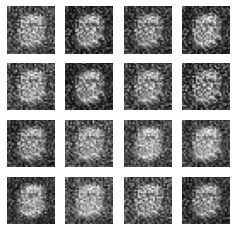

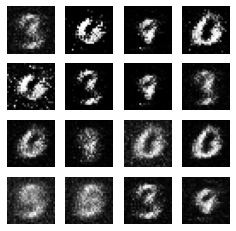

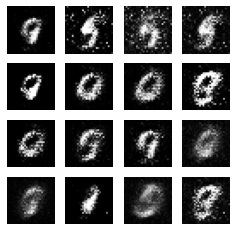

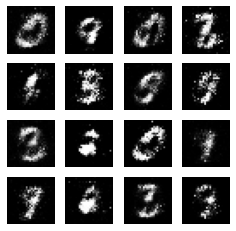

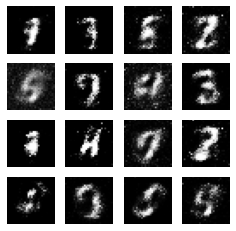

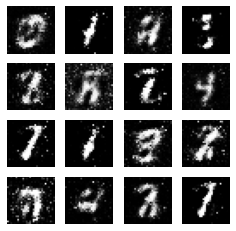

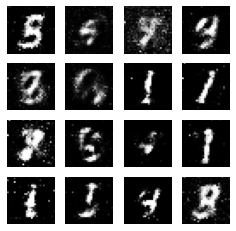

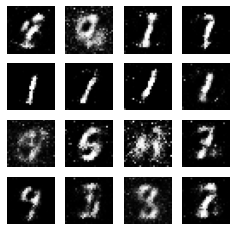

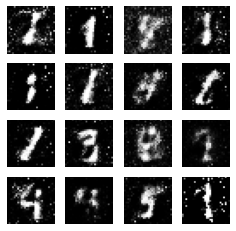

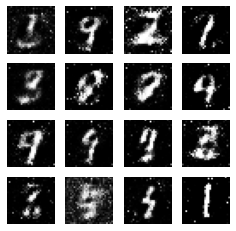

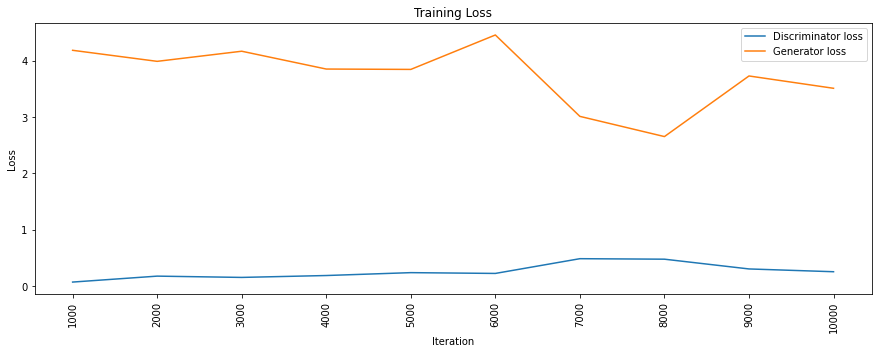

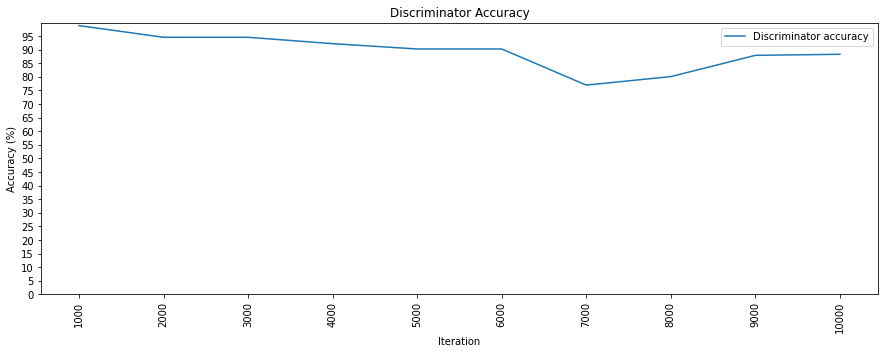

In [ ]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1


iterations = 10000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)

losses = np.array(losses)

plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

accuracies = np.array(accuracies)

plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()
 

### LeakyRelu 함수 사용 이유
 기존 relu 함수는 미분했을 때 0 or 1의 값을 가진다는 것은 어떤 레이어 하나에서 모든 노드의 미분 값이 0이 나온 다면 이후의 레이어에서 어떤 값이 나오건 학습이 이루어지지 않음.

- 이런 문제를 해결하는 활성화 함수는 Leaky relu입니다.

leaky relu는 임계치보다 작을 때 0을 출력하는 relu와는 달리 0.01을 곱합니다.

In [ ]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256,use_bias = False,input_shape=(100,)))
  #각각의 layer input 의 distribution 은 학습 중 이전 layer 의 변화에 의해 매번 달라진다. 
  #이를 막기 위해 각 층의 출력물을 다음 층에 입력하기 전에 평균 0, 표준편차 1 로 normalize 할 수 있다.
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))
  #배치 사이즈로 none이 주어집니다
  assert model.output_shape == (None,7,7,256) 

  model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
  assert model.output_shape == (None,7,7,128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())


  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model



### 훈련 되지 않은 생성자 이용해 이미지 생성

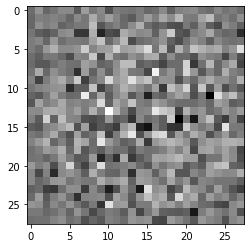

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
#진짜 값에는 양수, 가까 값에는 음수 출력
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00026736]], shape=(1, 1), dtype=float32)


In [ ]:
# 이 메서드는 크로스 엔트로피 손실함수 (cross entropy loss)를 계산하기 위해 헬퍼 (helper) 함수를 반환합니다.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

 감별자가 가짜 이미지에서 얼마나 진짜 이미지를 잘 판별하는지 수치화합니다. 진짜 이미지에 대한 감별자의 예측과 1로 이루어진 행렬을 비교하고, 가짜 (생성된) 이미지에 대한 감별자의 예측과 0으로 이루어진 행렬을 비교합니다.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### 생성자 손실함수  
생성자의 손실함수는 감별자를 얼마나 잘 속였는지에 대해 수치화를 합니다. 직관적으로 생성자가 원활히 수행되고 있다면, 감별자는 가짜 이미지를 진짜 (또는 1)로 분류를 할 것입니다. 여기서 우리는 생성된 이미지에 대한 감별자의 결정을 1로 이루어진 행렬과 비교를 할 것입니다.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
#감별자와 생성자는 따로 훈련되기 때문에, 감별자와 생성자의 옵티마이저는 다릅니다.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# 이 시드를 시간이 지나도 재활용하겠습니다. 
# (GIF 애니메이션에서 진전 내용을 시각화하는데 쉽기 때문입니다.) 
seed = tf.random.normal([num_examples_to_generate, noise_dim])

훈련 루프는 생성자가 입력으로 랜덤시드를 받는 것으로부터 시작됩니다. 그 시드값을 사용하여 이미지를 생성합니다. 감별자를 사용하여 (훈련 세트에서 갖고온) 진짜 이미지와 (생성자가 생성해낸) 가짜이미지를 분류합니다. 각 모델의 손실을 계산하고, 그래디언트 (gradients)를 사용해 생성자와 감별자를 업데이트합니다.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Reshape, Conv2D, Conv2DTranspose, Flatten, Dropout
from tensorflow.keras.models import Model
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = Input(shape=(latent_dim,))

x = Dense(128 * 16 * 16)(generator_input)
x = LeakyReLU()(x)
x = Reshape((16,16,128))(x)

x = Conv2DTranspose(256,4,strides=2,padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D(256,5,padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(256,5,padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = Model(generator_input,x)
generator.summary()

from tensorflow.keras.optimizers import RMSprop
discriminator_input = Input(shape=(height,width,channels))
x = Conv2D(128,3)(discriminator_input)
x = LeakyReLU()(x)
x = Conv2D(128,4,strides=2)(x)
x = LeakyReLU()(x)
x = Conv2D(128,4,strides=2)(x)
x = LeakyReLU()(x)
x = Conv2D(128,4,strides=2)(x)
x = LeakyReLU()(x)
x = Flatten()(x)

x = Dropout(0.4)(x)

x = Dense(1, activation='sigmoid')(x)

discriminator = Model(discriminator_input, x)
discriminator.summary()

discriminator_optimizer = RMSprop(learning_rate=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

discriminator.trainable = False

gan_input = Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

gan_optimizer = RMSprop(learning_rate=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_5 (Dense)             (None, 32768)             1081344   
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32768)             0         
                                                                 
 reshape_2 (Reshape)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 32, 32, 256)       0         
                                                           

In [ ]:
(X_train, ), (_, _) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_train = (X_train - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.
# X_train = X_train.reshape((X_train.shape[0],) + (height,width)).astype('float32') / 255. 

iterations = 10000
batch_size = 20
save_dir = './gan_images/'
if not os.path.exists(save_dir):
  os.mkdir(save_dir)

ValueError: ignored

In [ ]:
# 잠재 공간에서 무작위로 포인트를 샘플링(랜덤 노이즈)
labels = np.concatenate([np.ones((batch_size,1)), np.zeros((batch_size,1))])
labels += 0.05 * np.random.random(labels.shape)
start = 0
for step in range(iterations):
  random_latent_vectors = np.random.normal(size=(batch_size,latent_dim))
  # 랜덤 노이즈를 사용하여 generator 이미지를 생성(가짜 이미지를 디코딩)
  generated_images = generator.predict(random_latent_vectors)

  # 생성된 이미지와 진짜 이미지를 섞는다.
  stop = start + batch_size
  real_images = X_train[start:stop]
  combined_images = np.concatenate([generated_images, real_images])
  # 진짜와 가짜 이미지를 구분하여 레이블을 합침
  labels = np.concatenate([np.ones((batch_size,1)), np.zeros((batch_size,1))])
  # 레이블에 램덤 노이즈를 추가
  labels += 0.05 * np.random.random(labels.shape)

  # 진짜와 가짜가 섞인 이미지와 이에 대응하는 타깃을 사용하여 discriminator를 훈련
  d_loss = discriminator.train_on_batch(combined_images, labels)

  # 잠재 공간에서 무작위로 포인트를 샘플링
  random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

  # 모든 타깃은 진짜로 설정, 판별자가 생성된 이미지를 모두 진짜 이미지라고 예측하도록 생성자의 가중치를 업데이트
  # gan안에서 판별자는 동결되기 때문에 생성자만 업데이트, 결국 생성자는 판별자를 속이도록 훈련
  misleading_targets = np.zeros((batch_size,1))
  a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

  start += batch_size
  if start > len(x_train) - batch_size:
    start = 0

  if step % 100 == 0:
    gan.save_weights('gan.h5')

    print(f'스탭 {step}에서 판별자 손실: {d_loss} ')
    print(f'스탭 {step}에서 적대자 손실: {a_loss} ')

    # 생성된 이미지 하나를 저장
    img = image.array_to_img(generated_images[0] * 255.,scale=False)
    img.save(os.path.join(save_dir,'real_frog'+str(step)+'.png'))

ValueError: ignored

In [ ]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1


iterations = 10000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)

losses = np.array(losses)

plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

accuracies = np.array(accuracies)

plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()
 